# Multimodal search with CLIP

In this notebook we show-case SuperDuperDB's functionality for searching with multiple types of data over
the same `VectorIndex`. This comes out very naturally, due to the fact that SuperDuperDB allows
users and developers to add arbitrary models to SuperDuperDB, and (assuming they output vectors) use
these models at search/ inference time, to vectorize diverse queries.

To this end, we'll be using the [CLIP multimodal architecture](https://openai.com/research/clip).

In [4]:
!pip install git+https://github.com/openai/CLIP.git
!pip install datasets

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/pip-req-build-987fzqbd
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/pip-req-build-987fzqbd
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/74/a0/ec3868a14a0d0518e4559dd80b2f92259ddf58dbd39f27cf328ad294b22c/datasets-2.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec47891cdf05842d1a2366909ae4a0c89fbc5e6/multiprocess-0.70.15-py310-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 6.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8

So let's start. 

SuperDuperDB supports MongoDB as a databackend. Correspondingly, we'll import the python MongoDB client `pymongo`
and "wrap" our database to convert it to a SuperDuper `Datalayer`:

In [1]:
import clip
import pymongo
from superduperdb.misc.superduper import superduper
from superduperdb.models.torch.wrapper import TorchModel
from superduperdb.datalayer.mongodb.query import Collection
from superduperdb.core import Document as D
from superduperdb.encoders.pillow.image import pil_image as i
from IPython.display import display

pymongo.MongoClient().drop_database('documents')
pymongo.MongoClient().drop_database('_filesystem:documents')

db = pymongo.MongoClient().documents
db = superduper(db)

collection = Collection(name='tiny-imagenet')

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In order to make this notebook easy to execute an play with, we'll use a sub-sample of the [Tiny-Imagenet
dataset](https://paperswithcode.com/dataset/tiny-imagenet). 

Everything we are doing here generalizes to much larger datasets, with higher resolution images, without
further ado. For such use-cases, however, it's advisable to use a machine with a GPU, otherwise they'll 
be some significant thumb twiddling to do.

To get the images into the database, we use the `Encoder`-`Document` framework. This allows
us to save Python class instances as blobs in the `Datalayer`, but retrieve them as Python objects.
This makes it far easier to integrate Python AI-models with the datalayer.

To this end, SuperDuperDB contains pre-configured support for `PIL.Image` instances. It's also 
possible to create your own encoders.

In [2]:
from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i
from datasets import load_dataset
import random

dataset = load_dataset("zh-plus/tiny-imagenet")['valid']
dataset = [D({'image': i(r['image'])}) for r in dataset]
dataset = random.sample(dataset, 1000)


/Users/levkonstantinovskiy/Documents/GitHub/new/superduperdb-stealth/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The wrapped python dictionaries may be inserted directly to the `Datalayer`:

In [3]:
db.execute(collection.insert_many(dataset, encoders=(i,)))

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x176ed09d0>,
 TaskWorkflow(database=<superduperdb.datalayer.base.datalayer.Datalayer object at 0x16ccc4c70>, G=<networkx.classes.digraph.DiGraph object at 0x176ed1450>))

We can verify that the images are correctly stored:

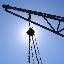

In [4]:
x = db.execute(collection.find_one())['image'].x
x

We now can wrap the CLIP model, to ready it for multimodel search. It involves 2 components:

- text-encoding
- visual-encoding

Once we have installed both parts, we will be able to search with both images and text for 
matching items:

In [5]:
from superduperdb.core.vector_index import VectorIndex
from superduperdb.core.watcher import Watcher
from superduperdb.encoders.torch.tensor import tensor
import torch

def add_clip_index(index_name, model_identifier, model, preprocess, text_tokenizer,):
    t = tensor(torch.float, shape=(512,))

    text_model = TorchModel(
        identifier=model_identifier+"_text",
        object=model,
        preprocess=text_tokenizer,
        forward_method='encode_text',
        encoder=t
    )
    print(len(text_model.predict('this is a test', one=True)))
    visual_model = TorchModel(
        identifier=model_identifier+"_image",
        preprocess=preprocess,
        object=model.visual,
        encoder=t,
    )
    x = db.execute(collection.find_one())['image'].x
    print(len(visual_model.predict(x, one=True)))


    db.add(
        VectorIndex(
            index_name,
            indexing_watcher=Watcher(
                model=visual_model,
                key='image',
                select=collection.find(),
            ),
            compatible_watcher=Watcher(
                model=text_model,
                key='text',
                active=False,
            )
        )
    )

In [6]:
openai_model, openai_preprocess = clip.load("ViT-B/32", device='cpu')
openai_tokenizer = lambda x: clip.tokenize(x)[0]
add_clip_index("openai_clip_index", "openai_clip_model", openai_model, openai_preprocess, openai_tokenizer,)


512
512


Computing chunk 0/0


100%|██████████| 1000/1000 [00:36<00:00, 27.51it/s]
INFO:root:loading hashes: 'openai_clip_index'
/Users/levkonstantinovskiy/Documents/GitHub/new/superduperdb-stealth/superduperdb/encoders/torch/tensor.py:25: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)


In [7]:

import open_clip
open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu' )
open_clip_tokenizer = lambda x: open_clip.get_tokenizer('ViT-B-32')(x)[0] 
add_clip_index("open_clip_clip_index", "open_clip_clip_model", open_clip_model, open_clip_preprocess, open_clip_tokenizer,)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpezj2fos9
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpezj2fos9/_remote_module_non_scriptable.py
INFO:root:Loaded ViT-B-32 model config.
INFO:root:Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


512
512


Computing chunk 0/0


100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]
INFO:root:loading hashes: 'open_clip_clip_index'


Let's verify this works:

Similar procedure with the visual part, which takes `PIL.Image` instances as inputs.

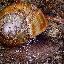

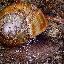

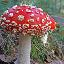

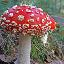

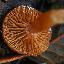

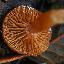

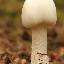

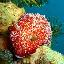

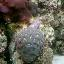

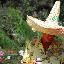

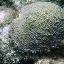

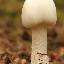

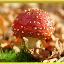

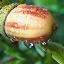

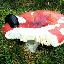

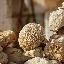

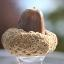

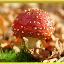

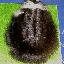

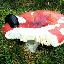

In [27]:
out_openai = db.execute(
    collection.like(D({'text': 'mushroom'}), vector_index='openai_clip_index', n=10).find({})
)
out_open_clip = db.execute(
    collection.like(D({'text': 'mushroom'}), vector_index='open_clip_clip_index', n=10).find({})
)

for r1, r2 in zip(out_openai, out_open_clip):
    display(r1['image'].x, r2['image'].x)

In [22]:
import pandas as pd
list_images = lambda out:[r['image'].x for r in out]
data = pd.DataFrame({"openai": list_images(out_openai), "open_clip": list_images(out_open_clip)})
#data.loc[:,'img'] = '<img src="data:image/png;base64,{0:s}">'
# html_all = data.to_html(escape=False).format(imgStr)
# display(HTML(html_all))
len(data)

10

In [23]:
from IPython.display import HTML
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

#pd.set_option('display.max_colwidth', -1)


def get_thumbnail(path):
    path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

HTML(data.to_html(formatters={'imagePILL': image_formatter}, escape=False))



,openai,open_clip
0,,
1,,
2,,
3,,
4,,
5,,
6,,
7,,
8,,
9,,


Now let's create the index for searching by vector. We register both models with the index simultaneously,
but specifying that it's the `visual_model` which will be responsible for creating the vectors in the database
(`indexing_watcher`). The `compatible_watcher` specifies how one can use an alternative model to search 
the vectors. By using models which expect different types of index, we can implement multimodal search
without further ado.

In [7]:
from superduperdb.core.vector_index import VectorIndex
from superduperdb.core.watcher import Watcher

db.add(
    VectorIndex(
        'openai-clip-index',
        indexing_watcher=Watcher(
            model=visual_model,
            key='image',
            select=collection.find(),
        ),
        compatible_watcher=Watcher(
            model=text_model,
            key='text',
            active=False,
        )
    )
)

NameError: name 'visual_model' is not defined

We can now demonstrate searching by text for images:

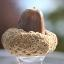

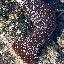

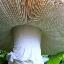

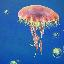

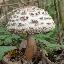

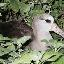

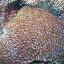

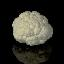

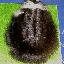

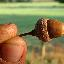

In [12]:
out = db.execute(
    collection.like(D({'text': 'mushroom'}), vector_index='openai-clip-index', n=10).find({})
)
for r in out:
    display(r['image'].x)

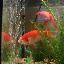

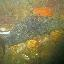

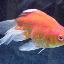

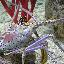

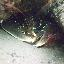

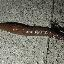

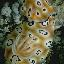

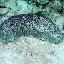

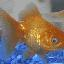

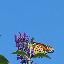

In [13]:
out = db.execute(
    collection.like(D({'text': 'fish'}), vector_index='openai-clip-index', n=10).find({})
)
for r in out:
    display(r['image'].x)

In [7]:
# import clip
# import pymongo
# from superduperdb.misc.superduper import superduper
# from superduperdb.models.torch.wrapper import TorchModel
# from superduperdb.datalayer.mongodb.query import Collection
# from superduperdb.core import Document as D
# from superduperdb.encoders.pillow.image import pil_image as i
# from IPython.display import display


In [14]:
# open clip
import open_clip
open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device='cpu' )
open_clip_tokenizer = open_clip.get_tokenizer('ViT-B-32')


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpx1tbbu_g
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/5k/k58wnkmx6x1cdgy02s9v8hnr0000gn/T/tmpx1tbbu_g/_remote_module_non_scriptable.py
INFO:root:Loaded ViT-B-32 model config.
INFO:root:Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


In [24]:


open_clip_text_model = TorchModel(
    identifier='open_clip_text',
    object=open_clip_model,
    preprocess=lambda x: open_clip_tokenizer(x)[0],
    forward_method='encode_text',
    encoder=t
)

In [25]:
#tokenizer('this is a test')[0]
len(open_clip_text_model.predict('this is a test', one=True))

512

In [26]:
open_clip_visual_model = TorchModel(
    identifier='openclip_image',
    preprocess=preprocess,
    object=open_clip_model.visual,
    encoder=t,
)

In [27]:
# import clip
# import pymongo
# from superduperdb.misc.superduper import superduper
# from superduperdb.models.torch.wrapper import TorchModel
# from superduperdb.datalayer.mongodb.query import Collection
# from superduperdb.core import Document as D
# from superduperdb.encoders.pillow.image import pil_image as i
# from IPython.display import display


# db = pymongo.MongoClient().documents
# db = superduper(db)

# collection = Collection(name='tiny-imagenet')

In [28]:
from superduperdb.core.vector_index import VectorIndex
from superduperdb.core.watcher import Watcher

db.add(
    VectorIndex(
        'openclip-index',
        indexing_watcher=Watcher(
            model=open_clip_visual_model,
            key='image',
            select=collection.find(),
        ),
        compatible_watcher=Watcher(
            model=open_clip_text_model,
            key='text',
            active=False,
        )
    )
)

Computing chunk 0/0


100%|██████████| 1000/1000 [00:38<00:00, 25.79it/s]
INFO:root:loading hashes: 'openclip-index'


[]

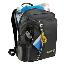

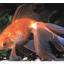

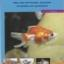

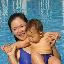

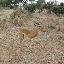

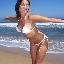

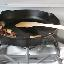

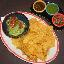

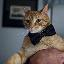

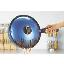

In [32]:
from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i

out = db.execute(
    collection.like(
        D({'text': 'mushroom'}), vector_index='openclip-index', n=10).find({})
)
for r in out:
    display(r['image'].x)

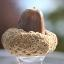

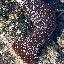

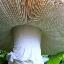

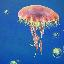

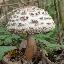

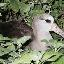

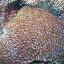

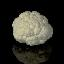

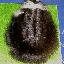

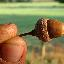

In [22]:
from superduperdb.core.document import Document as D
from superduperdb.encoders.pillow.image import pil_image as i

out = db.execute(
    collection.like(
        D({'text': 'mushroom'}), vector_index='openai-clip-index', n=10).find({})
)
for r in out:
    display(r['image'].x)

In [44]:
for i in db.vector_indices:
    print(i.index_information)

AttributeError: 'str' object has no attribute 'index_information'